# Evaluation script to execute it step by step
options, depending on network type
- `nn_config/SW_HR.yml`
- `nn_config/LW_HR.yml`
- `nn_config/SW_FLUX.yml`
- `nn_config/LW_FLUX.yml`

In [1]:
import yaml
with open("nn_config/SW_HR.yml", "r") as file:
    new_args = yaml.safe_load(file)

## imports, config and data loading

In [ ]:
import numpy as np
import os
import pickle
from matplotlib.colors import Normalize
import torch
import xarray as xr
import palettable as pt

#Custom imports
from plotter.predict import *
from plotter.shap import *
from plotter.map_plots import plot_map_lat_profile
from evaluation.predict import *
from evaluation.shap import *
import config
from utils.quick_helpers import label_translate

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

args = config.setup_args_and_load_data(False, False, new_args)

In [3]:

if "SW" in args.model_type:
    model_name = "Shortwave"
    hr="tend_ta_rsw"
    us="rsus" # upward flux surface
    ds="rsds" # downward flux surface
    ut="rsut" # upward flux toa
elif "LW" in args.model_type:
    model_name = "Longwave"
    hr="tend_ta_rlw"
    us="rlus" # upward flux surface
    ds="rlds" # downward flux surface
    ut="rlut" # upward flux toa

def get_results_and_summary(args):
    baseline_model = config.create_model(args.x_shape, args.y_shape, args.model_type, nft=args.norm_file, in_vars=args.variables["in_vars"], extra_shape=args.extra_shape, seed=args.seed)
    print(args.save_folder+"baseline_"+ args.model_type +"/model")
    
    if os.path.exists(args.model_path):
        baseline_model.load_state_dict(torch.load(args.model_path))
    else:
        baseline_model = config.load_from_checkpoint(args, args.extra_shape)
    
    if os.path.exists(args.result_file):
        print("Loading predictions...")
        with open(args.result_file, 'rb') as handle:
            results = pickle.load(handle)
        print("Done!")
    else:
        print("Predicting...")    
        results = predict(baseline_model.to("cpu"), args.coarse_test, args.norm_file, args.variables, args.model_type, args.y_mode)
        if "HR" in args.model_type:
            print(hr)
            results[f"true_{hr}"] = results[f"true_{hr}"]*86400
        with open(args.result_file, 'wb') as handle:
            pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print("Done!")
            
    
    summary_file = args.save_folder+'summary_'+ args.model_type + '_' + args.eval_on + '.pickle'
    if os.path.exists(summary_file):
        print("Loading summary...")
        with open(summary_file, 'rb') as handle:
            summary = pickle.load(handle)
        print("Done!")
    else:
        print("Calculating summary...")
        summary = summary_statistics(results, args.grid, args.model_type, args.variables["out_vars"])
        with open(summary_file, 'wb') as handle:
            pickle.dump(summary, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print("Done!")
    return results, summary, baseline_model

results, summary, baseline_model = get_results_and_summary(args)

varlist = [hr, us, ds, ut]
mean_pres = np.mean(results["extra_3d_pfull"], axis=0)
height=np.mean(args.vgrid["zfull"].values, axis=-1)/1000 # in km


results/preprocessing_toa/baseline_SW_HR/model
Loading predictions...
Done!
Loading summary...
Done!


## Flux plots

You only need this when evaluating the Flux NNs

In [ ]:

eval_plots(results[f"true_{ds}"], results[f"pred_{ds}"], f"{args.model_type} Downward Surface Flux", folder=args.result_folder)
eval_plots(results[f"true_{ut}"], results[f"pred_{ut}"], f"{args.model_type} Upward TOA Flux", folder=args.result_folder)
if "SW" in args.model_type:
    for v in args.variables["out_vars"][2:]:
        eval_plots(results[f"true_{v}"], results[f"pred_{v}"], f"{args.model_type} {v}", folder=args.result_folder)
        
print("First eval plots done!")
    

In [ ]:

if "FLUX" in args.model_type:
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
                    'Custom cmap', pt.colorbrewer.sequential.YlGnBu_4.mpl_colors[::-1], 4)
    vnames = [v for v in summary.keys() if "r2" in v]
    for v in vnames:
        if len(summary[v][0])>1:
            continue
        m = np.mean(summary[v])
        vn = v.removeprefix("r2_")
        print(vn, m )
        plot_map_lat_profile(summary["clat"].values, summary["clon"].values, summary[v], 
                                f"{label_translate(vn)}", label="$R^2$", cmap=cmap, lb=True,
                                norm=Normalize(0.8, vmax=1, clip=True), extend="min",
                                fname=f"{args.result_folder}{v}")

if args.model_type == "LW_FLUX":
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
                    'Custom cmap', pt.colorbrewer.sequential.YlGnBu_5.mpl_colors, 5)
    vnames = [v for v in summary.keys() if "mae" in v]
    for v in vnames:
        if len(summary[v][0])>1:
            continue
        m = np.mean(summary[v])
        vn = v.removeprefix("mae_")
        print(vn, m )
        plot_map_lat_profile(summary["clat"].values, summary["clon"].values, summary[v], 
                                f"{label_translate(vn)}", label="MAE [$W/m^2$]", cmap = cmap, lb=True,
                                norm=Normalize(0, vmax=5, clip=True), extend="max",
                                fname=f"{args.result_folder}{v}")
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
                    'Custom cmap', pt.colorbrewer.sequential.YlGnBu_4.mpl_colors, 4)
    vnames = [v for v in summary.keys() if "rel" in v]
    for v in vnames:
        if len(summary[v][0])>1:
            continue
        m = np.mean(summary[v])
        vn = v.removeprefix("rel_")
        print(vn, m )
        plot_map_lat_profile(summary["clat"].values, summary["clon"].values, summary[v], 
                                f"{label_translate(vn)}", label="Relative error", cmap=cmap,
                                norm=Normalize(0, vmax=0.05, clip=True), extend="max",
                                fname=f"{args.result_folder}{v}")
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
                    'Custom cmap', pt.colorbrewer.diverging.RdBu_5.mpl_colors[::-1], 5)
    vnames = [v for v in summary.keys() if "bias" in v]
    for v in vnames:
        if len(summary[v][0])>1:
            continue
        m = np.mean(summary[v])
        vn = v.removeprefix("bias_")
        print(vn, m )
        plot_map_lat_profile(summary["clat"].values, summary["clon"].values, summary[v], 
                                f"{label_translate(vn)}", label="Bias [$W/m^2$]",cmap=cmap, lb=True,
                                norm=Normalize(-2.5, vmax=2.5, clip=True), extend="both",
                                fname=f"{args.result_folder}{v}")
        
elif args.model_type == "SW_FLUX":
    
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
                    'Custom cmap', pt.colorbrewer.sequential.YlGnBu_4.mpl_colors, 4)
    vnames = [v for v in summary.keys() if "mae" in v]
    for v in vnames:
        if len(summary[v][0])>1:
            continue
        m = np.mean(summary[v])
        vn = v.removeprefix("mae_")
        print(vn, m )
        plot_map_lat_profile(summary["clat"].values, summary["clon"].values, summary[v], 
                                f"{label_translate(vn)}", label="MAE [$W/m^2$]", cmap=cmap, lb=True,
                                norm=Normalize(0, vmax=40, clip=True), extend="max",
                                fname=f"{args.result_folder}{v}")
    
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
                    'Custom cmap', pt.colorbrewer.sequential.YlGnBu_5.mpl_colors, 5)
    vnames = [v for v in summary.keys() if "rel" in v]
    for v in vnames:
        if len(summary[v][0])>1:
            continue
        m = np.mean(summary[v])
        vn = v.removeprefix("rel_")
        print(vn, m )
        plot_map_lat_profile(summary["clat"].values, summary["clon"].values, summary[v], 
                                f"{label_translate(vn)}", label="Relative error", cmap = cmap, lb=True,
                                norm=Normalize(0, vmax=0.5, clip=True), extend="max",
                                fname=f"{args.result_folder}{v}")
    
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
                    'Custom cmap', pt.colorbrewer.diverging.RdBu_5.mpl_colors[::-1], 5)
    vnames = [v for v in summary.keys() if "bias" in v]
    for v in vnames:
        if len(summary[v][0])>1:
            continue
        m = np.mean(summary[v])
        vn = v.removeprefix("bias_")
        print(vn, m )
        plot_map_lat_profile(summary["clat"].values, summary["clon"].values, summary[v], 
                                f"{label_translate(vn)}", label="Bias [$W/m^2$]",cmap=cmap, lb=True,
                                norm=Normalize(-12.5, vmax=12.5, clip=True), extend="both",
                                fname=f"{args.result_folder}{v}")

(1.0175514, 58.599586)


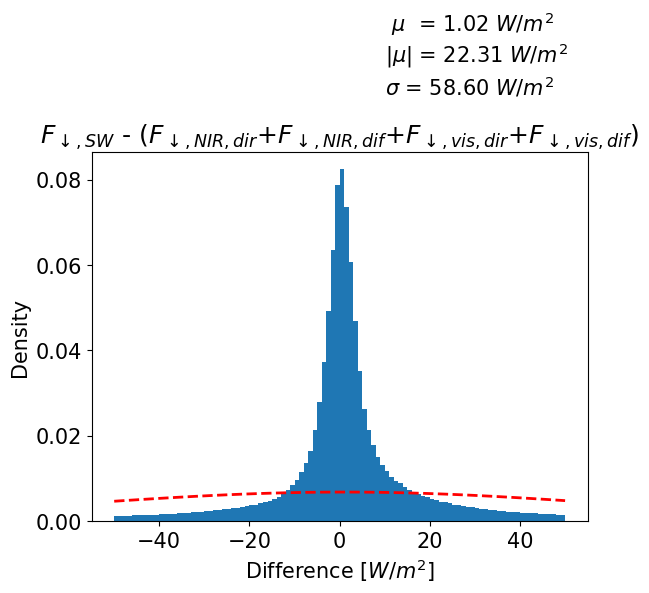

(1.0175514,
 22.309763,
 58.599586,
 -96.91643753051757,
 98.20223770141601,
 0.71147156)

In [11]:
results = results_flux
from scipy.stats import gamma,norm, lognorm, exponnorm, expon, laplace
import matplotlib as mpl
mpl.rcParams['font.size'] = '15'

norm = norm
diff = results["true_rsds"] - (results["pred_rvds_dir"] + results["pred_rvds_dif"] + results["pred_rnds_dir"] + results["pred_rnds_dif"])
params = norm.fit(diff)
print(params)
plt.figure()
n, bins, patches = plt.hist(diff, density=True, range=(-50,50), bins=100)
plt.title('$F_{\downarrow,SW}$ - ($F_{\downarrow, NIR, dir}$+$F_{\downarrow, NIR, dif}$+$F_{\downarrow, vis, dir}$+$F_{\downarrow, vis, dif}$)')
plt.xlabel("Difference [$W/m^2$]")
plt.ylabel("Density")
y = norm.pdf( bins, params[0], params[1])
l = plt.plot(bins, y, 'r--', linewidth=2)
m = np.mean(diff)
ma = np.mean(np.abs(diff))
s = np.std(diff)
text = f" $\\mu$  = {m:.2f} $W/m^2$ \n$|\mu|$ = {ma:.2f} $W/m^2$ \n$\sigma$ = {s:.2f} $W/m^2$"
plt.text(10,0.1,text, backgroundcolor="w")
#plt.grid()
plt.show()
plt.close()

m, ma, s, np.percentile(diff, 2.5), np.percentile(diff, 97.5), np.median(diff)

## Energy consistency

In [ ]:
from glob import glob
def load_data(base, exp):
    types = ["atm2d", "atm3d"]
    path = np.concatenate([glob(f"{base}{exp}/{exp}_{t}*19*.nc") for t in types])
    return xr.open_mfdataset(path)

base = "/path/to/data"
exp = "exp"
ref_ml = load_data(base, exp)
len_time = len(ref_ml.time)
ref_ml = ref_ml.isel(time = np.arange(1, len_time-1))

ref_ml 

In [8]:
net_toa_sw = ref_ml["extra_2d_in_toa_flux"] - ref_ml["extra_2d_out_rsut"]
rsds = ref_ml["extra_2d_out_rsds"]
net_surf_sw = rsds*(1-np.minimum(ref_ml["extra_2d_albedo"],1))
fnet_sw = ref_ml["extra_3d_out_tend_ta_rsw"] / ref_ml["qconv"]
cosmu = ref_ml["cosmu0_rt"]
diff = -net_surf_sw + net_toa_sw - fnet_sw.sum(dim="height") 
cos = cosmu.values
diff_sw = diff.values[cos>0].flatten()
diff_map_sw = diff.where(cos>0)
diff_map_sw_mean = diff_map_sw.mean(dim="time").values
diff_sw.shape

(5519347,)

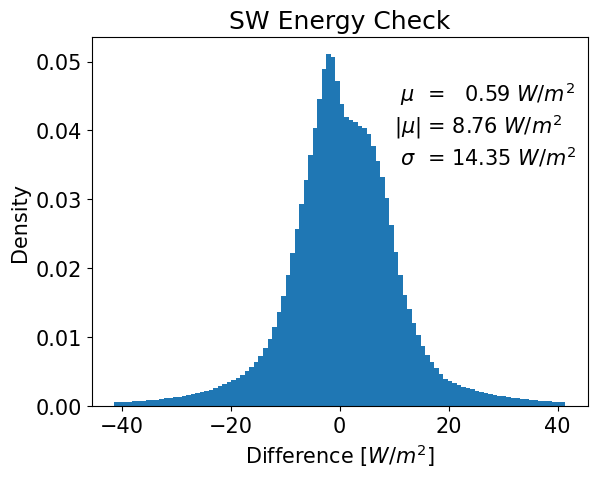

(0.592944, 8.764705, 14.353504, -41.20173767089844, 41.38187377929688)

In [9]:
p025 = np.percentile(diff_sw, 1)
p975 = np.percentile(diff_sw, 99)
xlim = np.max(np.abs([p025,p975]))
import matplotlib as mpl
mpl.rcParams['font.size'] = '15'

plt.hist(diff_sw, bins=100, density=True, range=(-xlim, xlim))
#plt.yscale("log")
plt.ylabel("Density")
plt.title("SW Energy Check")
plt.xlabel("Difference [$W/m^2$]")
m = np.mean(diff_sw)
am = np.mean(np.abs(diff_sw))
s = np.std(diff_sw)
text = f" $\\mu$  =   {m:.2f} $W/m^2$ \n$|\mu|$ = {am:.2f} $W/m^2$ \n $\sigma$  = {s:.2f} $W/m^2$"
plt.text(10,0.035,text, backgroundcolor="w")
plt.show()
plt.close()
m, am, s, p025, p975

In [10]:
idx2coords = np.load("idx_to_coords.npy") # lon, lat

In [11]:
from scipy.constants import sigma
net_toa_lw = - ref_ml["extra_2d_out_rlut"]
net_surf_lw = ref_ml["extra_2d_out_rlds"] - ref_ml["emissivity"]*sigma*ref_ml["extra_2d_in_ts"]**4
fnet_lw = ref_ml["extra_3d_out_tend_ta_rlw"] / ref_ml["qconv"]
diff = -net_surf_lw + net_toa_lw - fnet_lw.sum(dim="height") 
diff_lw = diff.values.flatten()
diff_map_lw = diff
diff_map_lw_mean = diff.mean(dim="time").values

In [ ]:
plot_map_lat_profile(idx2coords[:,1], idx2coords[:,0], diff_map_lw_mean, 
                    "LW energy check", label="Difference [$W/m^2$]", cmap="bwr", lb=True,
                    norm=Normalize(-10,10), extend="both")

(-1.0431911, 6.9388766, 11.715938, -36.216839904785154, 40.038992462158205)

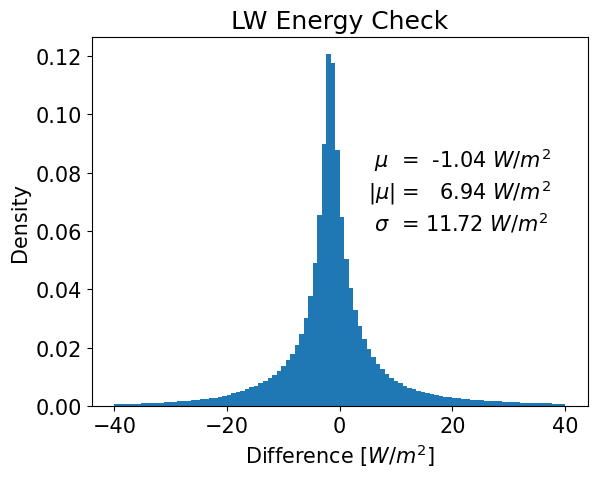

In [13]:
p025 = np.percentile(diff_lw, 1)
p975 = np.percentile(diff_lw, 99)
xlim = np.max(np.abs([p025,p975]))
plt.hist(diff_lw, bins=100, density=True, range=(-xlim, xlim))
#plt.yscale("log")
plt.ylabel("Density")
plt.title("LW Energy Check")
plt.xlabel("Difference [$W/m^2$]")
m = np.mean(diff_lw)
am = np.mean(np.abs(diff_lw))
s = np.std(diff_lw)
text = f" $\\mu$  =  {m:.2f} $W/m^2$ \n$|\mu|$ =   {am:.2f} $W/m^2$ \n $\sigma$  = {s:.2f} $W/m^2$"
plt.text(5,0.06,text, backgroundcolor="w")
m, am, s, p025, p975

## Heating rate Plots

You only need this when evaluating the heating rate NNs

In [4]:
clear_idx = results["clt"]==0
cloudy_idx = results["clt"]==1

results_clear = {}
results_cloudy = {}
for k in results.keys():
    print(k, results[k].shape)
    try:
        results_clear[k] = results[k][results["clt"]==0]
        results_cloudy[k] = results[k][results["clt"]==1]
    except:
        print("failed for ", k)
        continue

idx (1625028,)
t (1625028,)
extra_3d_cli (1625028, 47)
extra_3d_clw (1625028, 47)
extra_3d_hus (1625028, 47)
toa (1625028,)
extra_2d_albedo (1625028,)
o3 (1625028, 47)
cl (3209488, 47)
failed for  cl
rho (1625028, 47)
extra_3d_ta (1625028, 47)
extra_2d_prw (1625028,)
extra_2d_clivi (1625028,)
extra_2d_cllvi (1625028,)
extra_3d_pfull (1625028, 47)
clt (1625028,)
true_tend_ta_rsw (1625028, 47)
pred_tend_ta_rsw (1625028, 47)


---------------- All sky evaluation ----------------
[0.8, 0.8500000000000001, 0.9, 0.9500000000000001, 1.0, 1.05]
['0.8', '0.9', '0.9', '1.0', '1.0', '1.1']
results/preprocessing_toa/SW_HR_test/all_heating_rate_mae_r2_log 
  $R^2$ TOA = 0.9985 
 $R^2$ surf = 0.9262 
 $R^2$ = 0.9744 
 MAE TOA = 0.1026 (0.7918 %) 
 MAE surf = 0.0616 (5.5655 %)
 MAE = 0.0488 (2.50 %) 
 Bias TOA= 0.0154 (0.1193 %) 
 Bias surf = 0.0001 (0.0129 %) 
 Bias = 0.0051 (0.0223 %)



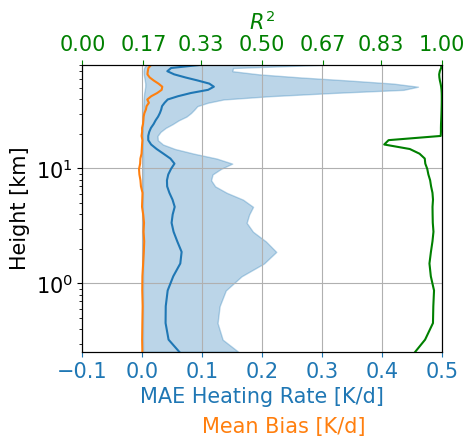

Profile plots done!
---------------- Clear sky evaluation ----------------
[0.8, 0.8500000000000001, 0.9, 0.9500000000000001, 1.0, 1.05]
['0.8', '0.9', '0.9', '1.0', '1.0', '1.1']
results/preprocessing_toa/SW_HR_test/clear_heating_rate_mae_r2_log 
  $R^2$ TOA = 0.9985 
 $R^2$ surf = 0.9871 
 $R^2$ = 0.9841 
 MAE TOA = 0.0987 (0.7368 %) 
 MAE surf = 0.0347 (2.1346 %)
 MAE = 0.0324 (1.31 %) 
 Bias TOA= 0.0193 (0.1440 %) 
 Bias surf = -0.0080 (-0.4893 %) 
 Bias = 0.0025 (-0.2302 %)



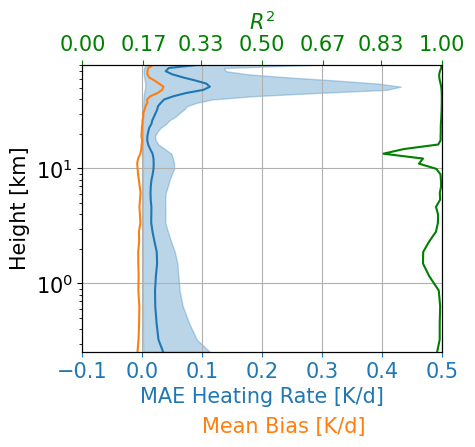

Profile plots done!
---------------- Cloudy sky evaluation ----------------
[0.8, 0.8500000000000001, 0.9, 0.9500000000000001, 1.0, 1.05]
['0.8', '0.9', '0.9', '1.0', '1.0', '1.1']
results/preprocessing_toa/SW_HR_test/cloudy_heating_rate_mae_r2_log 
  $R^2$ TOA = 0.9985 
 $R^2$ surf = 0.9306 
 $R^2$ = 0.9749 
 MAE TOA = 0.1051 (0.8381 %) 
 MAE surf = 0.0751 (8.4254 %)
 MAE = 0.0544 (3.10 %) 
 Bias TOA= 0.0160 (0.1280 %) 
 Bias surf = 0.0052 (0.5849 %) 
 Bias = 0.0066 (0.1456 %)



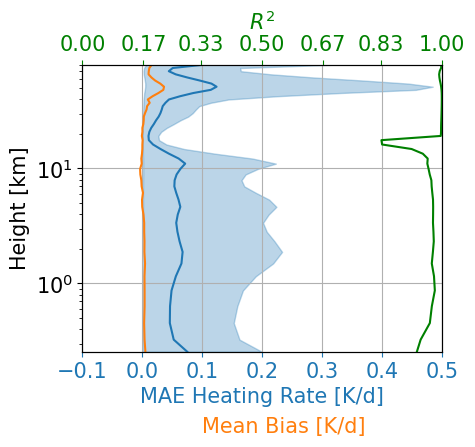

Profile plots done!
r2 minimum at index:  23


In [5]:
def hr_eval(true, pred, hr_id="all"):
    ta_hr = statistics(true, pred)
    if "SW" in args.model_type:
        xlim=(-.1,.5)
    elif "LW" in args.model_type:
        xlim=(-.2,1)
    for scale in ["log"]:
        plot_statistics_profile_height(ta_hr, height, "mae", "MAE Heating Rate [K/d]", scale, xlim=xlim, fname=args.result_folder+hr_id+"_heating_rate_mae_r2_"+scale)
        #plot_statistics_profile_height(ta_hr, height, "rel_mae_true", "Relative MAE Heating Rate", scale, fname=args.result_folder+hr_id+"_heating_rate_relative_mae_r2_"+scale)
        #plot_statistics_profile_height(ta_hr, height, "rmse", "RMSE Heating Rate [K/d]", scale, xlim=xlim, fname=args.result_folder+hr_id+"_heating_rate_rmse_r2_"+scale)
    
    print("Profile plots done!")
    #samples = [int(len(pred)*0.1 ), int(len(pred)*0.3 ), int(len(pred)*0.5 ), int(len(pred)*0.6 ), int(len(pred)*0.7 )]
    #os.makedirs(args.result_folder+"samples/", exist_ok=True)
    #scale="log"
    #plot_sample(true, pred, height, samples, "Heating Rate [K/d]", scale, ylabel = "Height [km]", fname=args.result_folder+"samples/"+hr_id+"_hr")
    
    return ta_hr
## all
print("---------------- All sky evaluation ----------------")
ta_hr = hr_eval(results[f"true_{hr}"],  results[f"pred_{hr}"], "all")

## clear sky
print("---------------- Clear sky evaluation ----------------")
ta_hr_clear = hr_eval(results_clear[f"true_{hr}"],  results_clear[f"pred_{hr}"], "clear")

## cloudy sky
print("---------------- Cloudy sky evaluation ----------------")
ta_hr_cloudy = hr_eval(results_cloudy[f"true_{hr}"],  results_cloudy[f"pred_{hr}"], "cloudy")
print("r2 minimum at index: ", np.argmin(ta_hr["r2"]))


In [ ]:
import palettable as pt
import matplotlib as mpl


res = ["all", "clear", "cloudy"]
title = "Shortwave" if "SW" in args.model_type else "Longwave"
h_per_x = args.vgrid["zfull"].values/1000
for r_idx, r in enumerate([results, results_clear, results_cloudy]):
    print(res[r_idx])
    for m in ["MAE", "Bias", "R^2", "o3", "extra_3d_ta", "rho"]:
        if m == "MAE":
            vals = np.abs(r[f"true_{hr}"]-r[f"pred_{hr}"])
            cmap =  mpl.colors.LinearSegmentedColormap.from_list(
                    'Custom cmap', pt.colorbrewer.sequential.YlGnBu_5.mpl_colors, 5)#"YlGnBu"
            norm=Normalize(vmin=0,vmax=0.5)
            summary_f = np.mean
            extend="max"
        elif m == "Bias":
            vals = r[f"true_{hr}"]-r[f"pred_{hr}"]
            cmap = mpl.colors.LinearSegmentedColormap.from_list(
                    'Custom cmap', pt.colorbrewer.diverging.RdBu_5.mpl_colors[::-1], 5)
            norm=Normalize(vmin=-.025,vmax=0.025)
            summary_f = np.mean
            extend="both"
        elif m == "R^2":
            vals = np.hstack((r[f"true_{hr}"][:,np.newaxis,:], r[f"pred_{hr}"][:,np.newaxis,:]))
            cmap = mpl.colors.LinearSegmentedColormap.from_list(
                    'Custom cmap', pt.colorbrewer.sequential.YlGnBu_5.mpl_colors, 5)
            
            def r2(data, axis=0):
                """
                 data shape (n, 2)
                """
                from sklearn.metrics import r2_score
                ytrue = data[:,0]
                ypred = data[:,1]
                r2 = r2_score(ytrue, ypred, multioutput="raw_values")
                return r2 
            norm=Normalize(vmin=0.8,vmax=1)
            summary_f = r2
            extend="min"
        elif m in r.keys():
            vals = r[m]
            summary_f = np.mean
            norm=Normalize(vmin=np.min(vals),vmax=np.max(vals))
            summary_f = np.mean
            extend="neither"
            cmap =  mpl.colors.LinearSegmentedColormap.from_list(
                    'Custom cmap', pt.colorbrewer.sequential.YlGnBu_5.mpl_colors, 5)
        else:
            print("Don't know mode ", m)
            break
        for s in ["log"]: # ["linear", "log"]
            pres_vs_lat(height, h_per_x[:,r["idx"]], args.grid["clat"].values[r["idx"]], vals, 
                        label=f"{m} Heating Rate [K/d]", norm=norm, extend=extend, ymode="height", title=f"{title}: {res[r_idx]}-sky",
                        fname=f"{args.result_folder}height_lat_{m}_{res[r_idx]}_{s}", scale=s, cmap=cmap, summary_f=summary_f)

In [ ]:
if "SW" in args.model_type:
    plot_map_lat_profile(summary["clat"].values, summary["clon"].values, np.mean(summary[f"mae_{hr}"], axis=1), 
                                args.model_type, label="MAE [$K/d$]", norm=Normalize(0.06, vmax=.2, clip=True), extend="both", 
                                fname=f"{args.result_folder}map_avg_mae_hr")
    plot_map_lat_profile(summary["clat"].values, summary["clon"].values, np.mean(summary[f"bias_{hr}"], axis=1), 
                                args.model_type, label="Bias [$K/d$]", norm=Normalize(-0.05, vmax=.05, clip=True), extend="both",cmap="seismic",
                                fname=f"{args.result_folder}map_avg_bias_hr" )
    plot_map_lat_profile(summary["clat"].values, summary["clon"].values, summary[f"mae_{hr}"][:,-1], 
                            "Near surface"+args.model_type, label="MAE [$K/d$]", norm=Normalize(0., vmax=.6, clip=True), extend="both", 
                            fname=f"{args.result_folder}map_avg_mae_hr_near_surface")
    plot_map_lat_profile(summary["clat"].values, summary["clon"].values, summary[f"bias_{hr}"][:,-1], 
                            "Near surface"+args.model_type, label="Bias [$K/d$]", norm=Normalize(-0.3, vmax=.3, clip=True), extend="both",cmap="seismic", 
                            fname=f"{args.result_folder}map_avg_bias_hr_near_surface")
elif "LW" in args.model_type:
    plot_map_lat_profile(summary["clat"].values, summary["clon"].values, np.mean(summary[f"mae_{hr}"], axis=1), 
                                args.model_type, label="MAE [$K/d$]", norm=Normalize(0.1, vmax=.25, clip=True), extend="both", 
                                fname=f"{args.result_folder}map_avg_mae_hr")
    plot_map_lat_profile(summary["clat"].values, summary["clon"].values, np.mean(summary[f"bias_{hr}"], axis=1), 
                                args.model_type, label="Bias [$K/d$]", norm=Normalize(-0.02, vmax=.02, clip=True), extend="both",cmap="seismic",
                                fname=f"{args.result_folder}map_avg_bias_hr" )
    plot_map_lat_profile(summary["clat"].values, summary["clon"].values, summary[f"mae_{hr}"][:,-1], 
                            "Near surface"+args.model_type, label="MAE [$K/d$]", norm=Normalize(0.25, vmax=1.8, clip=True), extend="both", 
                            fname=f"{args.result_folder}map_avg_mae_hr_near_surface")
    plot_map_lat_profile(summary["clat"].values, summary["clon"].values, summary[f"bias_{hr}"][:,-1], 
                            "Near surface"+args.model_type, label="Bias [$K/d$]", norm=Normalize(-1, vmax=1, clip=True), extend="both",cmap="seismic" ,
                            fname=f"{args.result_folder}map_avg_bias_hr_near_surface")

## Shap plots

In [9]:
model_specs = {
    "LW_FLUX": {
        "mtype": "LW_FLUX",
        "folder": "fluxes_new",
        "ymode": "vertical",
        "yxshift": -10,
        "yyshift": 0.8,
        "yshift": 0.25,
        "yrotate": 90,
        "vmin": 0.005,
    },
    "SW_FLUX": {
        "mtype": "SW_FLUX",
        "folder": "fluxes_mbe",
        "ymode": "vertical",
        "yxshift": -40,
        "yyshift": 0.5,
        "yshift": 2.5,
        "yrotate": 0,
        "vmin": 0.01,
    },
    "LW_HR": {
        "mtype": "LW_HR",
        "folder": "preprocessing_toa",
        "ymode": "horizontal",
        "yxshift": -15,
        "yyshift": 20,
        "yshift": 13,
        "yrotate": 90,
        "vmin": 0.5,
    },
    "SW_HR": {
        "mtype": "SW_HR",
        "folder": "preprocessing_toa",
        "ymode": "horizontal",
        "yxshift": -15,
        "yyshift": 20,
        "yshift": 13,
        "yrotate": 90,
        "vmin": 0.2,
    },
}

In [5]:
shapley_mean_vals = calculate_mean_shapley(baseline_model, args)

100%|██████████| 47/47 [01:35<00:00,  2.04s/it]

Shape: (331, 47)


7
[  5.   19.   40.   52.   66.   87.   99.  113.  134.  146.  160.  181.
 188.5 189.5 195.  209.  230.  242.  256.  277.  289.  303.  324. ] [1, 10, 50, 1, 10, 50, 1, 10, 50, 1, 10, 50, '', '', 1, 10, 50, 1, 10, 50, 1, 10, 50]


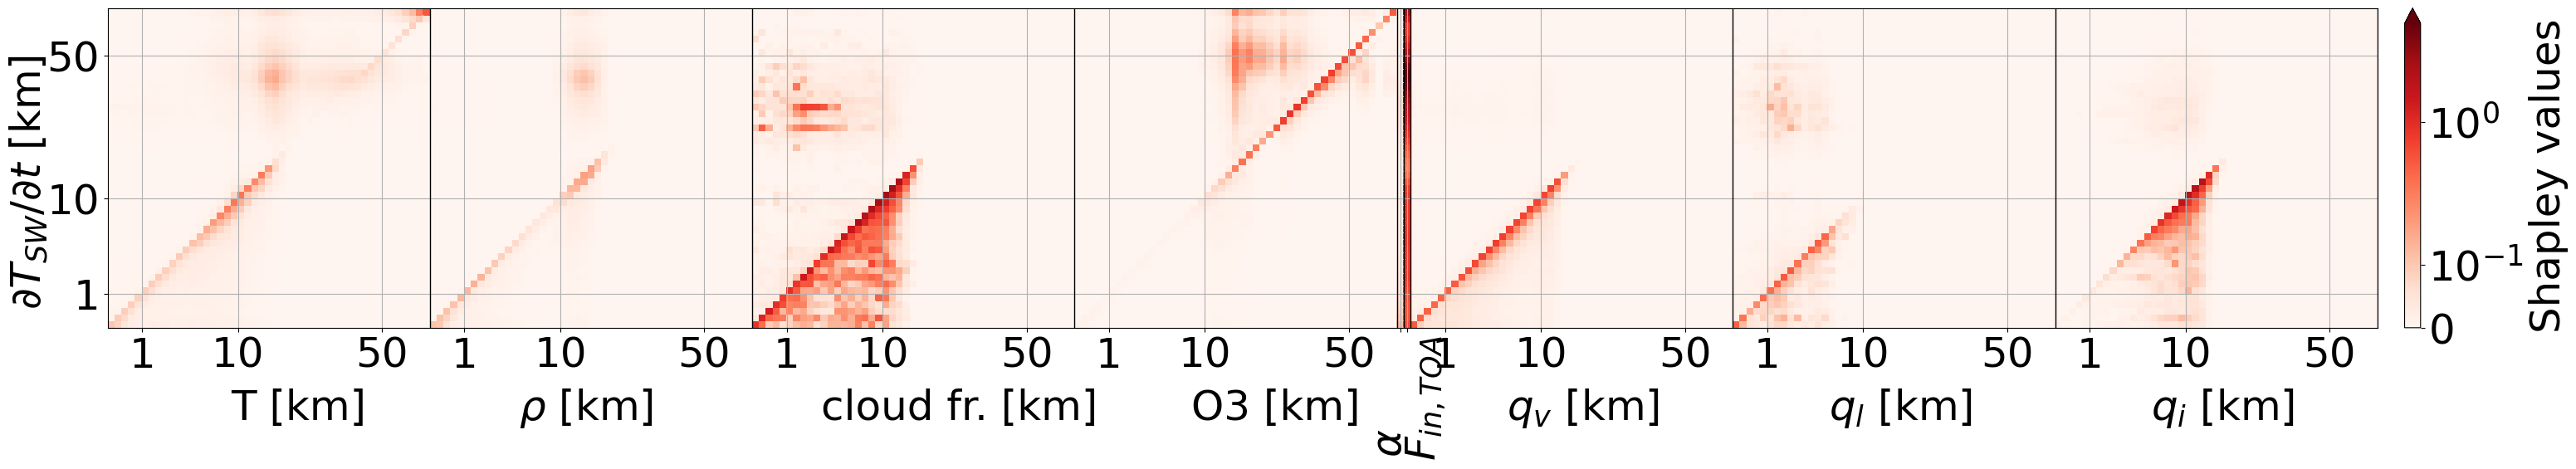

In [10]:
plot_interpret_values(shapley_mean_vals, height, args.variables, args.norm_file, model_specs[args.model_type])